# Loading Data

In [1]:
# For auto reloading of python files
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio
import random

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from src.dataloader import FanAudioDataset
from src.train import train_autoencoder
from src.autoencoder import FCAutoencoder, ConvAutoencoder, LSTMAutoencoder
from src.utils import plot_precision_recall_curve, find_optimal_threshold_from_pr, plot_precision_recall_vs_threshold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Load Data

In [4]:
spec_transform = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=512, power=2.0, normalized=True)

In [5]:
# Create train dataset and dataloader
train_dir = './data/bearing/train'
spec_train_dataset = FanAudioDataset(train_dir, transform=spec_transform)
spec_train_dataloader = DataLoader(spec_train_dataset, batch_size=8, shuffle=True)


In [6]:
input_dim = spec_train_dataset[0][0].shape[-1] * spec_train_dataset[0][0].shape[-2]
lstm_input_dim = spec_train_dataset[0][0].shape[-2]
epoch = 1

In [7]:
sample, _, _ = spec_train_dataset[0]
cnn_input_shape = sample.shape  
print("Input shape for CNN autoencoder:", cnn_input_shape)

Input shape for CNN autoencoder: torch.Size([1, 513, 313])


In [8]:
# Create test dataset and dataloader with labels
test_dir = './data/bearing/test'
spec_test_dataset = FanAudioDataset(test_dir, transform=spec_transform)
spec_test_dataloader = DataLoader(spec_test_dataset, batch_size=8, shuffle=False)

# Extract test labels from filenames
test_labels = []
test_filenames = [spec_test_dataset[i][2] for i in range(len(spec_test_dataset))]
for fname in test_filenames:
    if "normal" in fname.lower():
        test_labels.append(0)
    elif "anomaly" in fname.lower():
        test_labels.append(1)
    else:
        test_labels.append(-1)  # Unknown label
import numpy as np
test_labels = np.array(test_labels)

In [9]:
spec_vectors = []
for i in range(len(spec_train_dataset)):
    spec_spec, _, _ = spec_train_dataset[i]  # shape: [1, n_mels, time]
    spec_spec = spec_spec.squeeze(0)         # [n_mels, time]
    spec_vectors.append(spec_spec.flatten().cpu().numpy())
spec_vectors = np.stack(spec_vectors, axis=0)

# Local Outlier Factor

In [10]:
lof_model = LocalOutlierFactor(n_neighbors=3, novelty=True)
lof_model.fit(spec_vectors)

,n_neighbors,3
,algorithm,'auto'
,leaf_size,30
,metric,'minkowski'
,p,2
,metric_params,None
,contamination,'auto'
,novelty,True
,n_jobs,None


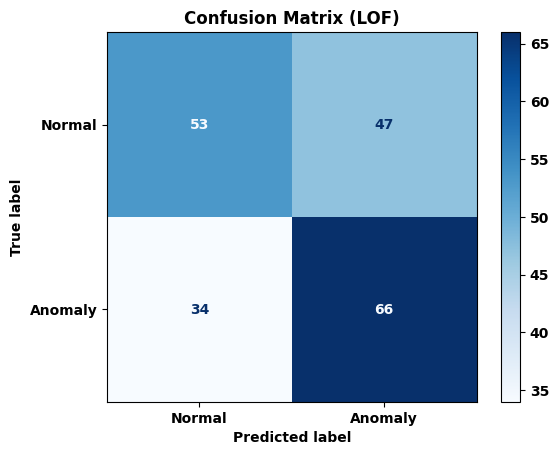

In [11]:
# Predict anomalies on test set using LOF and plot confusion matrix with new test_dataloader and test_labels
test_vectors = []
for batch in spec_test_dataloader:
    mel_specs, _, filenames = batch
    for mel_spec in mel_specs:
        mel_spec = mel_spec.squeeze(0)  # [n_mels, time]
        test_vectors.append(mel_spec.flatten().cpu().numpy())
test_vectors = np.stack(test_vectors, axis=0)  # [n_samples, n_features]

# Predict anomalies on test set (-1: anomaly, 1: normal)
test_preds = lof_model.predict(test_vectors)
test_preds_bin = np.where(test_preds == -1, 1, 0)  # 0=normal, 1=anomaly

# Use test_labels from earlier cell (already 0=normal, 1=anomaly, -1=unknown)
valid_idx = test_labels != -1
test_labels_valid = test_labels[valid_idx]
test_preds_valid = test_preds_bin[valid_idx]

cm = confusion_matrix(test_labels_valid, test_preds_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (LOF)")
plt.show()

In [12]:
# Get LOF anomaly scores (negative_outlier_factor_: lower = more anomalous)
lof_scores = -lof_model.decision_function(test_vectors)  # higher = more anomalous

roc_auc = roc_auc_score(test_labels_valid, lof_scores)
print(f"ROC AUC (LOF): {roc_auc:.3f}")

accuracy = np.mean(test_preds_valid == test_labels_valid)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Add classification report
print("\nClassification Report (LOF):")
print(classification_report(test_labels_valid, test_preds_valid, 
                          target_names=["Normal", "Anomaly"]))

ROC AUC (LOF): 0.678
Accuracy: 59.50%

Classification Report (LOF):
              precision    recall  f1-score   support

      Normal       0.61      0.53      0.57       100
     Anomaly       0.58      0.66      0.62       100

    accuracy                           0.59       200
   macro avg       0.60      0.59      0.59       200
weighted avg       0.60      0.59      0.59       200



# Isolation Forest

In [13]:
# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(spec_vectors)

,n_estimators,100
,max_samples,'auto'
,contamination,0.1
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


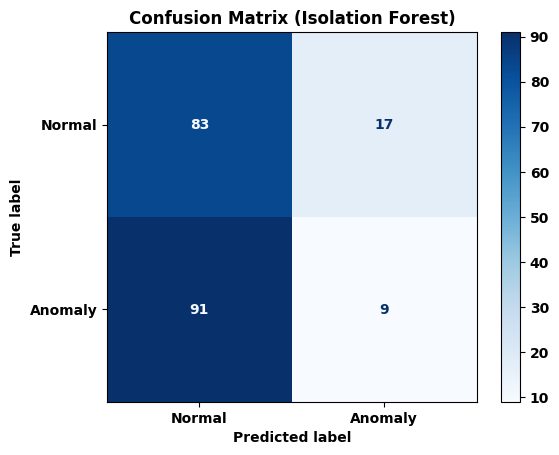

In [14]:
# Predict anomalies on test set using Isolation Forest and plot confusion matrix with new test_dataloader and test_labels
test_vectors = []
for batch in spec_test_dataloader:
    spec_specs, _, filenames = batch
    for spec_spec in spec_specs:
        spec_spec = spec_spec.squeeze(0)  # [n_mels, time]
        test_vectors.append(spec_spec.flatten().cpu().numpy())
test_vectors = np.stack(test_vectors, axis=0)  # [n_samples, n_features]

# Predict anomalies on test set (-1: anomaly, 1: normal)
test_preds = iso_forest.predict(test_vectors)
test_preds_bin = np.where(test_preds == -1, 1, 0)  # 0=normal, 1=anomaly

# Use test_labels from earlier cell (already 0=normal, 1=anomaly, -1=unknown)
valid_idx = test_labels != -1
test_labels_valid = test_labels[valid_idx]
test_preds_valid = test_preds_bin[valid_idx]


cm = confusion_matrix(test_labels_valid, test_preds_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Isolation Forest)")
plt.show()

In [15]:
anomaly_scores = -iso_forest.decision_function(test_vectors)  # higher = more anomalous

roc_auc = roc_auc_score(test_labels_valid, anomaly_scores)

print(f"ROC AUC: {roc_auc:.3f}")

accuracy = np.mean(test_preds_valid == test_labels_valid)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Add classification report
print("\nClassification Report (Isolation Forest):")
print(classification_report(test_labels_valid, test_preds_valid, 
                          target_names=["Normal", "Anomaly"]))

ROC AUC: 0.488
Accuracy: 46.00%

Classification Report (Isolation Forest):
              precision    recall  f1-score   support

      Normal       0.48      0.83      0.61       100
     Anomaly       0.35      0.09      0.14       100

    accuracy                           0.46       200
   macro avg       0.41      0.46      0.37       200
weighted avg       0.41      0.46      0.37       200



# Fully Connected Auto-encoder

In [16]:
fc_model = FCAutoencoder(input_dim=input_dim, bottleneck_dim=512)
fc_model = train_autoencoder(fc_model, spec_train_dataloader, num_epochs=epoch)

Epoch 1/1, Loss: 0.265788
Training complete.


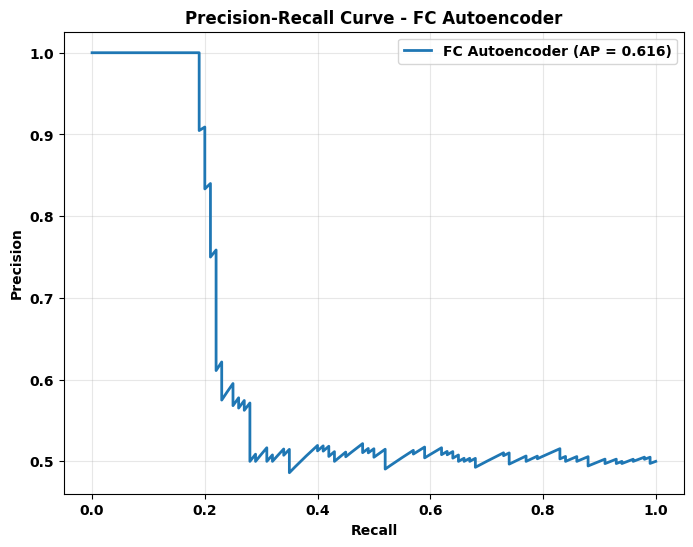

AUC Score: 0.5356
Optimal threshold (Precision-Recall Intersection): 0.234360
Precision: 0.510, Recall: 0.510
Threshold: 0.23435969650745392


In [17]:
fc_precision, fc_recall, fc_thresholds, fc_ap, fc_auc = plot_precision_recall_curve(
    fc_model, spec_test_dataloader, test_labels, 'fc', 'FC Autoencoder'
)
print(f"AUC Score: {fc_auc}")
threshold, _ = find_optimal_threshold_from_pr(fc_precision, fc_recall, fc_thresholds, metric="intercept")
print(f"Threshold: {threshold}")

F1 scores range: [0.020, 0.669]
Valid F1 scores (>0): 200/200


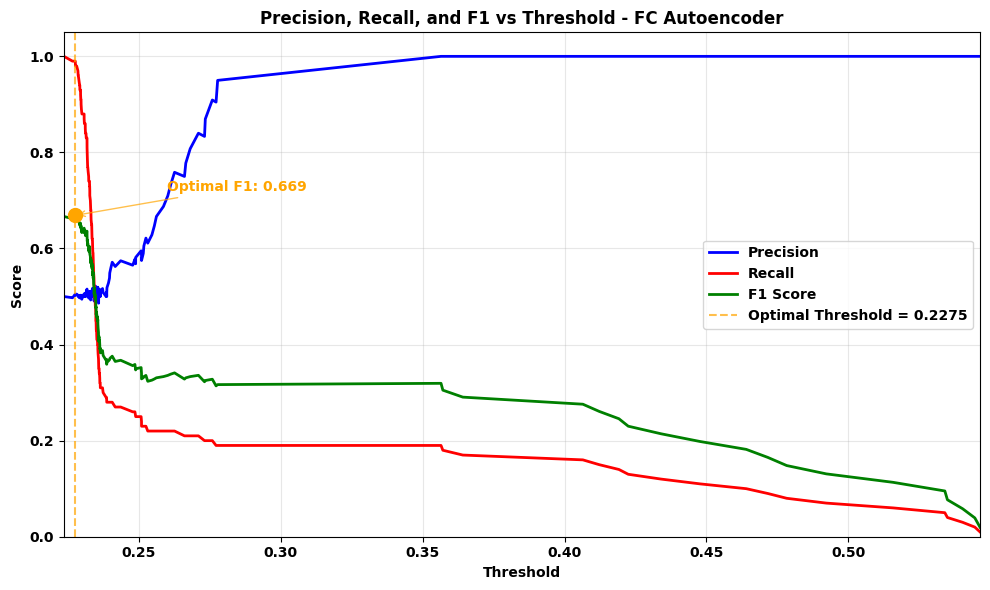

Optimal threshold: 0.227547
At optimal threshold - Precision: 0.505, Recall: 0.990, F1: 0.669


In [18]:
fc_precision, fc_recall, fc_thresholds, fc_optimal = plot_precision_recall_vs_threshold(
    fc_model, spec_test_dataloader, test_labels, 'fc', 'FC Autoencoder'
)

Correctly detected: 101 / 200 (50.50%)


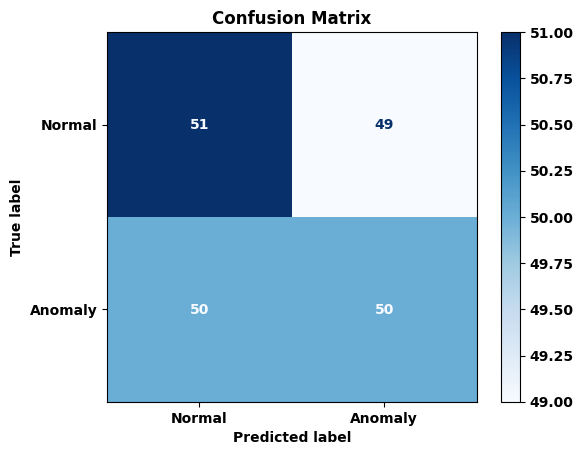

In [19]:
fc_model.eval()
test_errors = []
test_filenames = []
with torch.no_grad():
    for batch in spec_test_dataloader:
        spec_specs, _, filenames = batch
        x = spec_specs.squeeze(1).view(spec_specs.size(0), -1)
        x = x.to(fc_model.encoder[0].weight.device)
        recon = fc_model(x)
        errors = torch.mean((x - recon) ** 2, dim=1)
        test_errors.extend(errors.cpu().numpy())
        test_filenames.extend(filenames)
test_preds = (np.array(test_errors) > threshold).astype(int)  # 0=normal, 1=anomaly

test_labels = np.array(test_labels)
correct = np.sum(test_preds == test_labels)
total = len(test_labels)
print(f"Correctly detected: {correct} / {total} ({100.0 * correct / total:.2f}%)")

cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print("\nClassification Report (FC Autoencoder):")
print(classification_report(test_labels, test_preds, 
                          target_names=["Normal", "Anomaly"]))


Classification Report (FC Autoencoder):
              precision    recall  f1-score   support

      Normal       0.50      0.51      0.51       100
     Anomaly       0.51      0.50      0.50       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



In [21]:
torch.save(fc_model.state_dict(), 'models/spec_fc_autoencoder.pth')
del fc_model
torch.cuda.empty_cache()

# CNN Auto-encoder

In [22]:
conv_model = ConvAutoencoder(in_channels=1, enc_flat_dim=(128,33,20))
conv_model = train_autoencoder(conv_model, spec_train_dataloader, num_epochs=epoch, flatten=False, patience=3)

Epoch 1/1, Loss: 0.176242
Training complete.


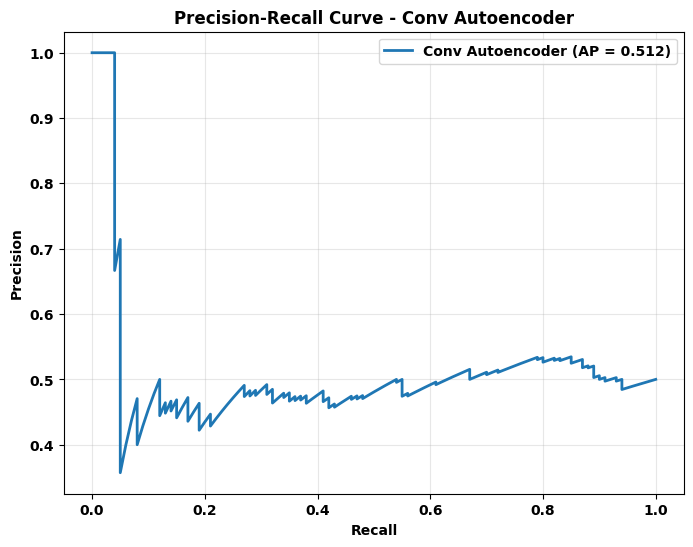

AUC Score: 0.49360000000000004
Optimal threshold (F1): 0.045403, F1 Score: 0.667
Threshold: 0.045403216034173965


In [23]:
conv_precision, conv_recall, conv_thresholds, conv_ap, conv_roc = plot_precision_recall_curve(
    conv_model, spec_test_dataloader, test_labels, 'conv', 'Conv Autoencoder'
)

print(f"AUC Score: {conv_roc}")
threshold, _ = find_optimal_threshold_from_pr(conv_precision, conv_recall, conv_thresholds, metric="f1", beta=0.3)
print(f"Threshold: {threshold}")

F1 scores range: [0.020, 0.667]
Valid F1 scores (>0): 200/200


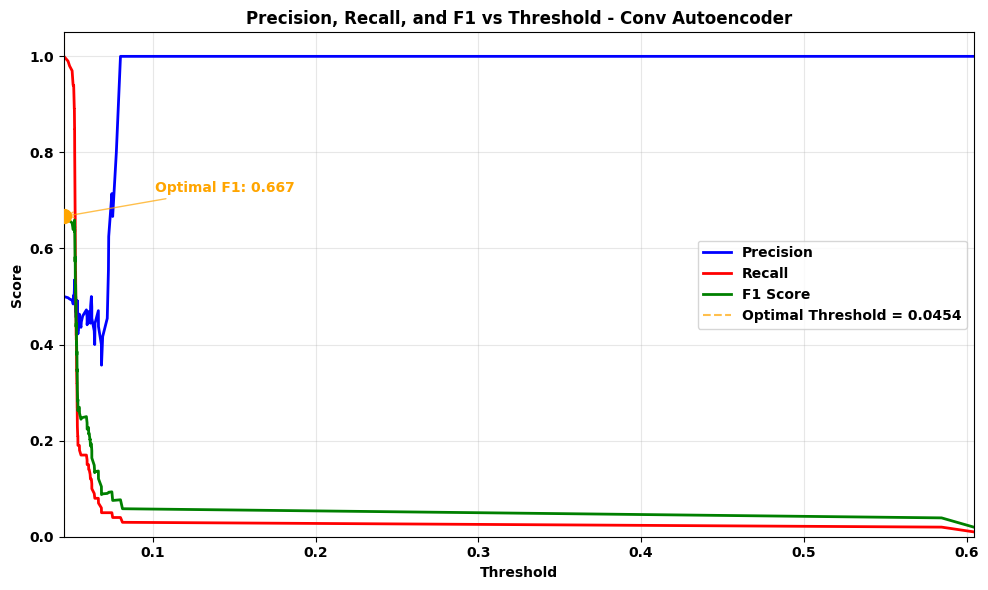

Optimal threshold: 0.045403
At optimal threshold - Precision: 0.500, Recall: 1.000, F1: 0.667


In [24]:
conv_precision, conv_recall, conv_thresholds, conv_optimal = plot_precision_recall_vs_threshold(
    conv_model, spec_test_dataloader, test_labels, 'conv', 'Conv Autoencoder'
)

Correctly detected: 99 / 200 (49.50%)


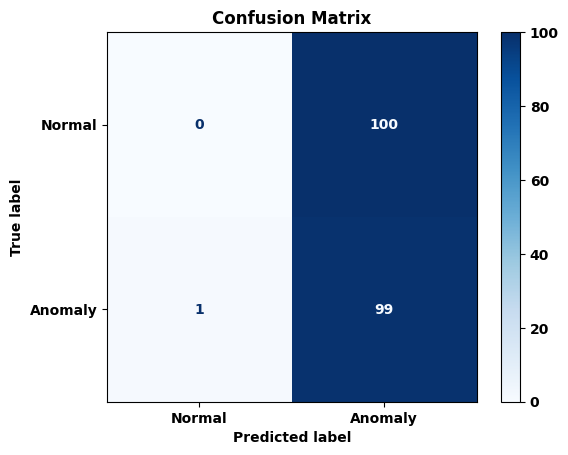

In [25]:
# threshold= 0.002855
conv_model.eval()
test_errors = []
test_filenames = []
with torch.no_grad():
    for batch in spec_test_dataloader:
        spec_specs, _, filenames = batch
        x = spec_specs.to(conv_model.encoder[0].weight.device)
        recon = conv_model(x)
        errors = torch.mean((x - recon) ** 2, dim=(1, 2, 3))
        test_errors.extend(errors.cpu().numpy())
        test_filenames.extend(filenames)
test_preds = (np.array(test_errors) > threshold).astype(int)  # 0=normal, 1=anomaly

# Ensure test_labels is a numpy array and filter out unknown labels (-1)
test_labels = np.array(test_labels)
valid_idx = test_labels != -1
test_labels_valid = test_labels[valid_idx]
test_preds_valid = test_preds[valid_idx]

correct = np.sum(test_preds_valid == test_labels_valid)
total = len(test_labels_valid)
print(f"Correctly detected: {correct} / {total} ({100.0 * correct / total:.2f}%)")

cm = confusion_matrix(test_labels_valid, test_preds_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [26]:
print("\nClassification Report (Conv Autoencoder):")
print(classification_report(test_labels_valid, test_preds_valid, 
                          target_names=["Normal", "Anomaly"]))


Classification Report (Conv Autoencoder):
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       100
     Anomaly       0.50      0.99      0.66       100

    accuracy                           0.49       200
   macro avg       0.25      0.49      0.33       200
weighted avg       0.25      0.49      0.33       200



# LSTM Auto-encoder

In [27]:
from src.train import train_lstm_autoencoder
lstm_model = LSTMAutoencoder(input_size=lstm_input_dim, hidden_size=256, num_layers=3)
lstm_model = train_lstm_autoencoder(lstm_model, spec_train_dataloader, num_epochs=epoch, flatten=False)

Epoch 1/1, Loss: 0.000007
Training complete.


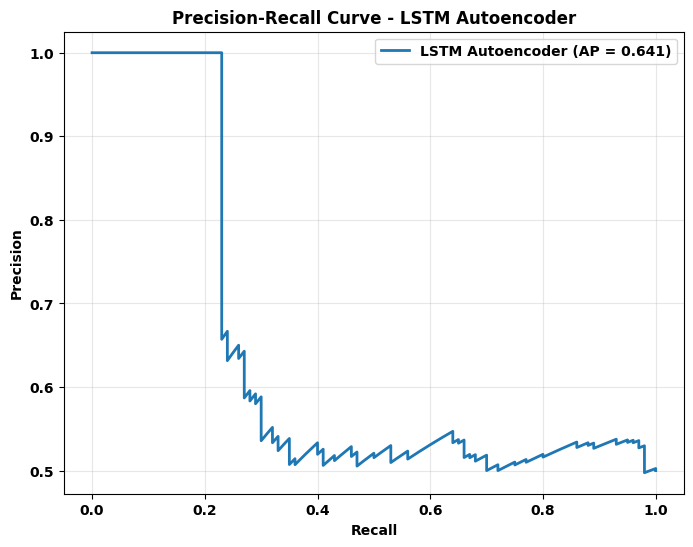

AUC Score:0.5722
Optimal threshold (Precision-Recall Intersection): 0.000000
Precision: 0.530, Recall: 0.530
Threshold: 1.986798991993055e-08


In [28]:
lstm_precision, lstm_recall, lstm_thresholds, lstm_ap, lstm_auc = plot_precision_recall_curve(
    lstm_model, spec_test_dataloader, test_labels, 'lstm', 'LSTM Autoencoder'
)
print(f"AUC Score:{lstm_auc}")
threshold, _ = find_optimal_threshold_from_pr(lstm_precision, lstm_recall, lstm_thresholds, metric="intercept")
print(f"Threshold: {threshold}")

F1 scores range: [0.020, 0.690]
Valid F1 scores (>0): 200/200


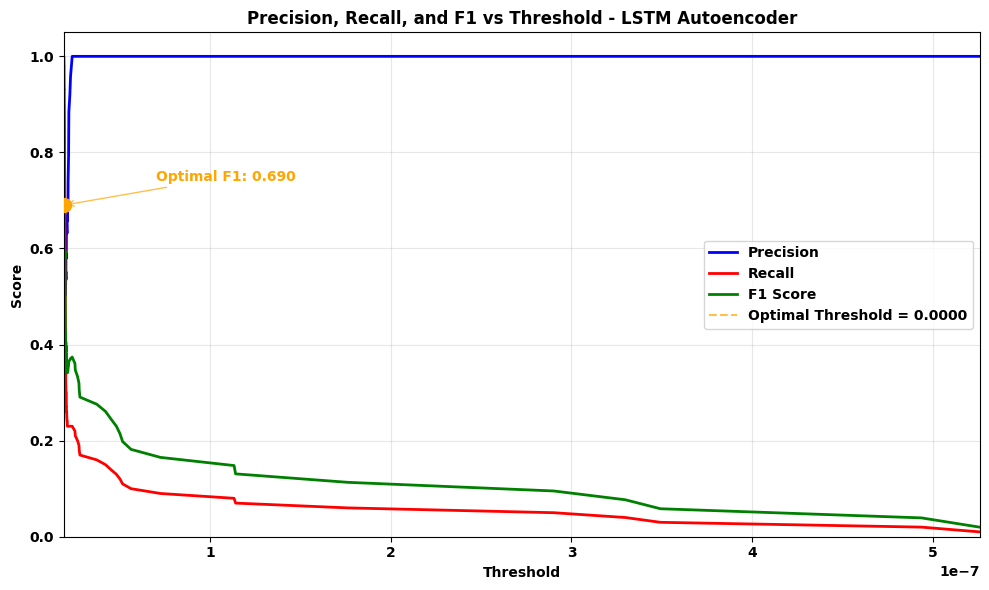

Optimal threshold: 0.000000
At optimal threshold - Precision: 0.536, Recall: 0.970, F1: 0.690


In [29]:
lstm_precision, lstm_recall, lstm_thresholds, lstm_optimal = plot_precision_recall_vs_threshold(
    lstm_model, spec_test_dataloader, test_labels, 'lstm', 'LSTM Autoencoder'
)

Correctly detected: 105 / 200 (52.50%)


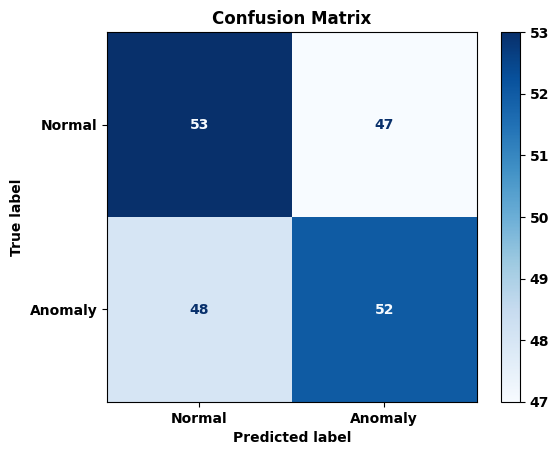

In [30]:
lstm_model.eval()
test_errors = []
test_filenames = []
with torch.no_grad():
    for batch in spec_test_dataloader:
        spec_specs, _, filenames = batch
        x = spec_specs.squeeze(1).permute(0, 2, 1).to(next(lstm_model.parameters()).device)
        recon = lstm_model(x)
        errors = torch.mean((x - recon) ** 2, dim=(1, 2))
        test_errors.extend(errors.cpu().numpy())
        test_filenames.extend(filenames)
test_preds = (np.array(test_errors) > threshold).astype(int) 

# Ensure test_labels is a numpy array and filter out unknown labels (-1)
test_labels = np.array(test_labels)
valid_idx = test_labels != -1
test_labels_valid = test_labels[valid_idx]
test_preds_valid = test_preds[valid_idx]

correct = np.sum(test_preds_valid == test_labels_valid)
total = len(test_labels_valid)
print(f"Correctly detected: {correct} / {total} ({100.0 * correct / total:.2f}%)")

cm = confusion_matrix(test_labels_valid, test_preds_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [31]:
print("\nClassification Report (LSTM Autoencoder):")
print(classification_report(test_labels_valid, test_preds_valid, 
                          target_names=["Normal", "Anomaly"]))


Classification Report (LSTM Autoencoder):
              precision    recall  f1-score   support

      Normal       0.52      0.53      0.53       100
     Anomaly       0.53      0.52      0.52       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.52       200
weighted avg       0.53      0.53      0.52       200



In [32]:
# torch.save(fc_model.state_dict(), 'models/spec_fc_autoencoder.pth')
torch.save(conv_model.state_dict(), 'models/spec_conv_autoencoder.pth')
torch.save(lstm_model.state_dict(), 'models/spec_lstm_autoencoder.pth')

In [33]:
# fc_model = FCAutoencoder(input_dim=input_dim, bottleneck_dim=512)
# fc_model.load_state_dict(torch.load('fc_autoencoder.pth'))
# fc_model.eval()